<a href="https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/train_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [ ]:
# Copyright 2020 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Train & Timbre Transfer--DDSP Autoencoder on GPU--48kHz/Stereo

Made by [Google Magenta](https://magenta.tensorflow.org/)--altered by [Demon Flex Council](https://soundcloud.com/demonflexcouncil)

This notebook demonstrates how to install the DDSP library and train it for synthesis based on your own data using command-line scripts. If run inside of Colab, it will automatically use a free Google Cloud GPU.

**A Little Background**

A producer friend of mine turned me on to Magenta’s DDSP, and I’m glad he did. In my mind it represents the way forward for AI music. Finally we have a glimpse inside the black box, with access to musical parameters as well as neural net hyperparameters. And DDSP leverages decades of studio knowledge by utilizing traditional processors like synthesizers and effects. One can envision a time when DDSP-like elements will sit at the heart of production DAWs.

DDSP will accept most audio sample rates and formats. However, native 48kHz/stereo datasets and primers will sound best. Output files are always 48kHz/stereo. You can upload datasets and primers via the browser or use Google Drive.

The algorithm was designed to model single instruments played monophonically, but it can also produce interesting results with denser, polyphonic material and percussion.

<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


**Note that we prefix bash commands with a `!` inside of Colab, but you would leave them out if running directly in a terminal.**

### Install Dependencies

First we install the required dependencies with `pip`.

In [1]:
%tensorflow_version 2.x
!pip install -qU ddsp[data_preparation]

# Initialize global path for using google drive. 
DRIVE_DIR = ''

# Helper Functions
sample_rate = 48000
n_fft = 2048

     |████████████████████████████████| 153kB 8.0MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 3.6MB 15.1MB/s 
     |████████████████████████████████| 8.7MB 62.8MB/s 
     |████████████████████████████████| 368kB 60.8MB/s 
     |████████████████████████████████| 2.0MB 58.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 63.8MB 46kB/s 
     |████████████████████████████████| 112kB 66.0MB/s 
ERROR: apache-beam 2.25.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement dill<0.3.2,>=0.3.1.1, but you'll have dill 0.3.2 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement future<1.0.0,>=0.18.2, but you'll have future 0.16.0 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement requests<3.

### Setup Google Drive (Optional, Recommeded)

This notebook requires uploading audio and saving checkpoints. While you can do this with direct uploads / downloads, it is recommended to connect to your google drive account. This will enable faster file transfer, and regular saving of checkpoints so that you do not lose your work if the colab kernel restarts (common for training more than 12 hours). 

#### Login and mount your drive

This will require an authentication code. You should then be able to see your drive in the file browser on the left panel.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Set your base directory
* In drive, put all of the audio files with which you would like to train in a single folder.
 * Typically works well with 10-20 minutes of audio from a single monophonic source (also, one acoustic environment). 
* Use the file browser in the left panel to find a folder with your audio, right-click **"Copy Path", paste below**, and run the cell.

In [3]:
#@markdown (ex. `/content/drive/My Drive/...`) Leave blank to skip loading from Drive.
DRIVE_DIR = '/content/drive/My Drive/DDSP--Ny2' #@param {type: "string"}

import os
assert os.path.exists(DRIVE_DIR)
print('Drive Folder Exists:', DRIVE_DIR)


Drive Folder Exists: /content/drive/My Drive/DDSP--Ny2


### Make directories to save model and data

In [4]:
!git clone https://github.com/DemonFlexCouncil/gin.git
GIN_FILE = 'gin/solo_instrument.gin'

AUDIO_DIR_LEFT = 'data/audio-left'
AUDIO_DIR_RIGHT = 'data/audio-right'
MODEL_DIR_LEFT = 'data/model-left'
MODEL_DIR_RIGHT = 'data/model-right'
AUDIO_FILEPATTERN_LEFT = AUDIO_DIR_LEFT + '/*'
AUDIO_FILEPATTERN_RIGHT = AUDIO_DIR_RIGHT + '/*'
!mkdir -p $AUDIO_DIR_LEFT $AUDIO_DIR_RIGHT $MODEL_DIR_LEFT $MODEL_DIR_RIGHT

if DRIVE_DIR:
  SAVE_DIR_LEFT = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument-left')
  SAVE_DIR_RIGHT = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument-right')
  INPUT_DIR = os.path.join(DRIVE_DIR, 'dataset-input')
  PRIMERS_DIR = os.path.join(DRIVE_DIR, 'primers')
  OUTPUT_DIR = os.path.join(DRIVE_DIR, 'resynthesis-output')

  !mkdir -p "$SAVE_DIR_LEFT" "$SAVE_DIR_RIGHT" "$INPUT_DIR" "$PRIMERS_DIR" "$OUTPUT_DIR"

Cloning into 'gin'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


### Upload training audio

Upload training audio to the "dataset-input" folder inside the DRIVE_DIR folder if using Drive (otherwise prompts local upload.)

In [5]:
import glob
import os
from ddsp.colab import colab_utils

from google.colab import files

import librosa
import numpy as np

from scipy.io.wavfile import write as write_audio

if DRIVE_DIR:
  wav_files = glob.glob(os.path.join(INPUT_DIR, '*.wav'))
  aiff_files = glob.glob(os.path.join(INPUT_DIR, '*.aiff'))
  aif_files = glob.glob(os.path.join(INPUT_DIR, '*.aif'))
  ogg_files = glob.glob(os.path.join(INPUT_DIR, '*.ogg'))
  flac_files = glob.glob(os.path.join(INPUT_DIR, '*.flac'))
  mp3_files = glob.glob(os.path.join(INPUT_DIR, '*.mp3'))
  audio_files = wav_files + aiff_files + aif_files + ogg_files + flac_files + mp3_files
else:
  uploaded_files = files.upload()
  audio_files = list(uploaded_files.keys())

for fname in audio_files:
  # Convert to 48kHz.
  audio, unused_sample_rate = librosa.load(fname, sr=48000, mono=False)
  if (audio.ndim == 2):
    audio = np.swapaxes(audio, 0, 1)
  # Mono to stereo.
  if (audio.ndim == 1):
    print('Converting mono to stereo.')
    audio = np.stack((audio, audio), axis=-1)
  target_name_left = os.path.join(AUDIO_DIR_LEFT, 
                             os.path.basename(fname).replace(' ', '_').replace('aiff', 'wav').replace('aif', 'wav').replace('ogg', 'wav').replace('flac', 'wav').replace('mp3', 'wav'))
  target_name_right = os.path.join(AUDIO_DIR_RIGHT, 
                             os.path.basename(fname).replace(' ', '_').replace('aiff', 'wav').replace('aif', 'wav').replace('ogg', 'wav').replace('flac', 'wav').replace('mp3', 'wav'))
  # Split to dual mono.
  write_audio(target_name_left, sample_rate, audio[:, 0])
  write_audio(target_name_right, sample_rate, audio[:, 1])

### Preprocess raw audio into TFRecord dataset

We need to do some preprocessing on the raw audio you uploaded to get it into the correct format for training. This involves turning the full audio into short (4-second) examples, inferring the fundamental frequency (or "pitch") with [CREPE](http://github.com/marl/crepe), and computing the loudness. These features will then be stored in a sharded [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) file for easier loading. Depending on the amount of input audio, this process usually takes a few minutes.

* (Optional) Transfer dataset from drive. If you've already created a dataset, from a previous run, this cell will skip the dataset creation step and copy the dataset from `$DRIVE_DIR/data` 

In [6]:
import glob
import os

TRAIN_TFRECORD_LEFT = 'data/train-left.tfrecord'
TRAIN_TFRECORD_RIGHT = 'data/train-right.tfrecord'
TRAIN_TFRECORD_FILEPATTERN_LEFT = TRAIN_TFRECORD_LEFT + '*'
TRAIN_TFRECORD_FILEPATTERN_RIGHT = TRAIN_TFRECORD_RIGHT + '*'

# Copy dataset from drive if dataset has already been created.
drive_data_dir = os.path.join(DRIVE_DIR, 'data') 
drive_dataset_files = glob.glob(drive_data_dir + '/*')

if DRIVE_DIR and len(drive_dataset_files) > 0:
  !cp "$drive_data_dir"/* data/

else:
  # Make a new dataset.
  if (not glob.glob(AUDIO_FILEPATTERN_LEFT)) or (not glob.glob(AUDIO_FILEPATTERN_RIGHT)):
    raise ValueError('No audio files found. Please use the previous cell to '
                    'upload.')

  !ddsp_prepare_tfrecord \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN_LEFT \
    --output_tfrecord_path=$TRAIN_TFRECORD_LEFT \
    --num_shards=10 \
    --sample_rate=$sample_rate \
    --alsologtostderr

  !ddsp_prepare_tfrecord \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN_RIGHT \
    --output_tfrecord_path=$TRAIN_TFRECORD_RIGHT \
    --num_shards=10 \
    --sample_rate=$sample_rate \
    --alsologtostderr

  # Copy dataset to drive for safe-keeping.
  if DRIVE_DIR:
    !mkdir "$drive_data_dir"/
    print('Saving to {}'.format(drive_data_dir))
    !cp $TRAIN_TFRECORD_FILEPATTERN_LEFT "$drive_data_dir"/
    !cp $TRAIN_TFRECORD_FILEPATTERN_RIGHT "$drive_data_dir"/

2020-11-03 22:20:37.411212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1103 22:20:40.949838 139826266961792 translations.py:613] ==================== <function annotate_downstream_side_inputs at 0x7f2bd1bef730> ====================
I1103 22:20:40.950570 139826266961792 translations.py:613] ==================== <function fix_side_input_pcoll_coders at 0x7f2bd1bef840> ====================
I1103 22:20:40.950983 139826266961792 translations.py:613] ==================== <function eliminate_common_key_with_none at 0x7f2bd1bef950> ====================
I1103 22:20:40.951386 139826266961792 translations.py:613] ==================== <function pack_combiners at 0x7f2bd1bef9d8> ====================
I1103 22:20:40.951639 139826266961792 translations.py:613] ==================== <function lift_combiners at 0x7f2bd1befa60> ====================
I1103 22:20:40.951813 139826266961792 translations.py:613] ==================== <fu

### Save dataset statistics for timbre transfer

Quantile normalization helps match loudness of timbre transfer inputs to the loudness of the dataset, so let's calculate it here and save in a pickle file.

**Note:** If you encounter an error here, try increasing the dataset size to about 5 minutes of total audio or more. Duplicate the files if necessary. If you still get an error, move directly to the training step. Not having a statistics file will still allow you to do timbre transfer, but you won't be able to modify the conditioning.

In [7]:
from ddsp.colab import colab_utils
import ddsp.training

data_provider_left = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_LEFT, sample_rate=sample_rate)
data_provider_right = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_RIGHT, sample_rate=sample_rate)
dataset_left = data_provider_left.get_dataset(shuffle=False)
dataset_right = data_provider_right.get_dataset(shuffle=False)

if DRIVE_DIR:
  PICKLE_FILE_PATH_LEFT = os.path.join(SAVE_DIR_LEFT, 'dataset_statistics_left.pkl')
  PICKLE_FILE_PATH_RIGHT = os.path.join(SAVE_DIR_RIGHT, 'dataset_statistics_right.pkl')
else:
  PICKLE_FILE_PATH_LEFT = os.path.join(MODEL_DIR_LEFT, 'dataset_statistics_left.pkl')
  PICKLE_FILE_PATH_RIGHT = os.path.join(MODEL_DIR_RIGHT, 'dataset_statistics_right.pkl')

colab_utils.save_dataset_statistics(data_provider_left, PICKLE_FILE_PATH_LEFT)
colab_utils.save_dataset_statistics(data_provider_right, PICKLE_FILE_PATH_RIGHT)

Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x7f347104e278>
batch: 1
Done! Saved to: /content/drive/My Drive/DDSP--Ny2/ddsp-solo-instrument-left/dataset_statistics_left.pkl
Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x7f347104e438>
batch: 1
Done! Saved to: /content/drive/My Drive/DDSP--Ny2/ddsp-solo-instrument-right/dataset_statistics_right.pkl


Let's load the dataset in the `ddsp` library and have a look at one of the examples.

Top: Left, Bottom: Right


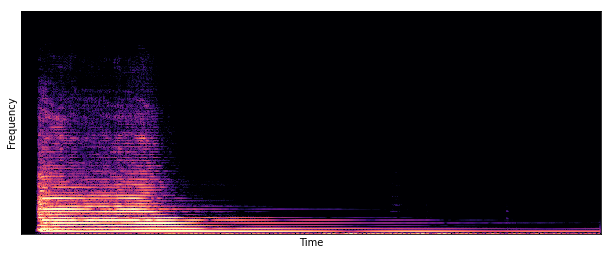

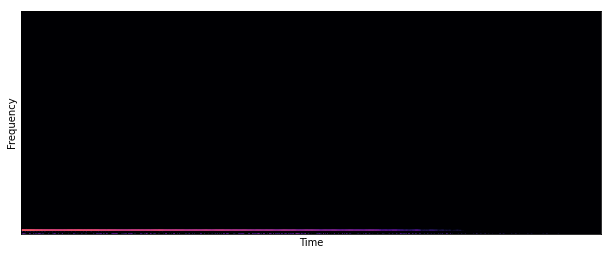

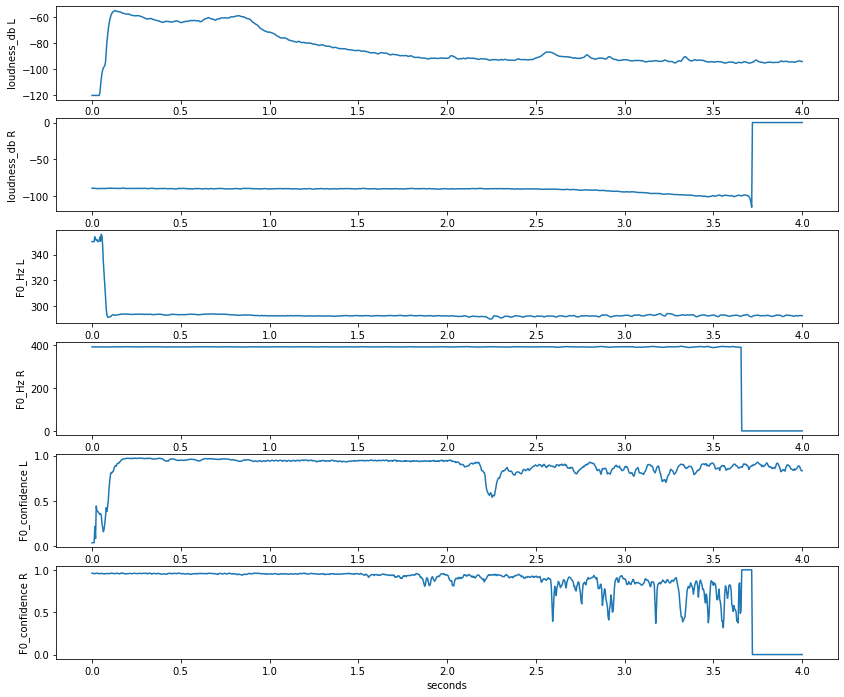

In [9]:
from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

data_provider_left = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_LEFT, sample_rate=sample_rate)
dataset_left = data_provider_left.get_dataset(shuffle=False)

data_provider_right = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_RIGHT, sample_rate=sample_rate)
dataset_right = data_provider_right.get_dataset(shuffle=False)

try:
  ex_left = next(iter(dataset_left))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

try:
  ex_right = next(iter(dataset_right))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

print('Top: Left, Bottom: Right')
colab_utils.specplot(ex_left['audio'])
colab_utils.specplot(ex_right['audio'])

f, ax = plt.subplots(6, 1, figsize=(14, 12))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db L')
ax[0].plot(x, ex_left['loudness_db'])
ax[1].set_ylabel('loudness_db R')
ax[1].plot(x, ex_right['loudness_db'])
ax[2].set_ylabel('F0_Hz L')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex_left['f0_hz'])
ax[3].set_ylabel('F0_Hz R')
ax[3].set_xlabel('seconds')
ax[3].plot(x, ex_right['f0_hz'])
ax[4].set_ylabel('F0_confidence L')
ax[4].set_xlabel('seconds')
ax[4].plot(x, ex_left['f0_confidence'])
ax[5].set_ylabel('F0_confidence R')
ax[5].set_xlabel('seconds')
ax[5].plot(x, ex_right['f0_confidence'])


### Train Model

We will now train a "solo instrument" model. This means the model is conditioned only on the fundamental frequency (f0) and loudness with no instrument ID or latent timbre feature. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

First, let's start up a [TensorBoard](https://www.tensorflow.org/tensorboard) to monitor our loss as training proceeds. 

Initially, TensorBoard will report `No dashboards are active for the current data set.`, but once training begins, the dashboards should appear.

In [ ]:
%reload_ext tensorboard
import tensorboard as tb
if DRIVE_DIR:
  tb.notebook.start('--logdir "{}"'.format(SAVE_DIR_LEFT))
  tb.notebook.start('--logdir "{}"'.format(SAVE_DIR_RIGHT))
else:
  tb.notebook.start('--logdir "{}"'.format(MODEL_DIR_LEFT))
  tb.notebook.start('--logdir "{}"'.format(MODEL_DIR_RIGHT))

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

#### Training Notes:
* Models typically perform well when the loss drops to the range of ~5.0-7.0.
* Depending on the dataset this can take anywhere from 5k-40k training steps usually.
* On the colab GPU, this can take from around 3-24 hours. 
* We **highly recommend** saving checkpoints directly to your drive account as colab will restart naturally after about 12 hours and you may lose all of your checkpoints.
* By default, checkpoints will be saved every 250 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [ ]:
#@markdown Enter number of steps to train. Restart runtime to interrupt training.

NUM_STEPS = 24000 #@param {type:"slider", min: 1000, max:40000, step:1000}
NUM_LOOPS = int(NUM_STEPS / 1000)

if DRIVE_DIR:
  TRAIN_DIR_LEFT = SAVE_DIR_LEFT
  TRAIN_DIR_RIGHT = SAVE_DIR_RIGHT
else:
  TRAIN_DIR_LEFT = MODEL_DIR_LEFT
  TRAIN_DIR_RIGHT = MODEL_DIR_RIGHT

for i in range (0, NUM_LOOPS):
  !ddsp_run \
    --mode=train \
    --alsologtostderr \
    --save_dir="$TRAIN_DIR_LEFT" \
    --gin_file="$GIN_FILE" \
    --gin_file=datasets/tfrecord.gin \
    --gin_param="TFRecordProvider.file_pattern='$TRAIN_TFRECORD_FILEPATTERN_LEFT'" \
    --gin_param="batch_size=6" \
    --gin_param="train_util.train.num_steps=1000" \
    --gin_param="train_util.train.steps_per_save=250" \
    --gin_param="trainers.Trainer.checkpoints_to_keep=10"

  !ddsp_run \
    --mode=train \
    --alsologtostderr \
    --save_dir="$TRAIN_DIR_RIGHT" \
    --gin_file="$GIN_FILE" \
    --gin_file=datasets/tfrecord.gin \
    --gin_param="TFRecordProvider.file_pattern='$TRAIN_TFRECORD_FILEPATTERN_RIGHT'" \
    --gin_param="batch_size=6" \
    --gin_param="train_util.train.num_steps=1000" \
    --gin_param="train_util.train.steps_per_save=250" \
    --gin_param="trainers.Trainer.checkpoints_to_keep=10"

  # Remove extra gin files.
  if DRIVE_DIR:
    !cd "$SAVE_DIR_LEFT" && mv "operative_config-0.gin" "$DRIVE_DIR"
    !cd "$SAVE_DIR_LEFT" && rm operative_config*
    !cd "$DRIVE_DIR" && mv "operative_config-0.gin" "$SAVE_DIR_LEFT"
    !cd "$SAVE_DIR_RIGHT" && mv "operative_config-0.gin" "$DRIVE_DIR"
    !cd "$SAVE_DIR_RIGHT" && rm operative_config*
    !cd "$DRIVE_DIR" && mv "operative_config-0.gin" "$SAVE_DIR_RIGHT"
  else:
    !cd "$MODEL_DIR_LEFT" && mv "operative_config-0.gin" "$AUDIO_DIR_LEFT"
    !cd "$MODEL_DIR_LEFT" && rm operative_config*
    !cd "$AUDIO_DIR_LEFT" && mv "operative_config-0.gin" "$MODEL_DIR_LEFT"
    !cd "$MODEL_DIR_RIGHT" && mv "operative_config-0.gin" "$AUDIO_DIR_RIGHT"
    !cd "$MODEL_DIR_RIGHT" && rm operative_config*
    !cd "$AUDIO_DIR_RIGHT" && mv "operative_config-0.gin" "$MODEL_DIR_RIGHT"

Streaming output truncated to the last 5000 lines.
I1104 05:13:53.857217 139910314436480 train_util.py:225] step: 10122	spectral_loss: 5.33	total_loss: 5.33	
I1104 05:13:54.973139 139910314436480 train_util.py:225] step: 10123	spectral_loss: 5.62	total_loss: 5.62	
I1104 05:13:56.093763 139910314436480 train_util.py:225] step: 10124	spectral_loss: 5.46	total_loss: 5.46	
I1104 05:13:57.178446 139910314436480 train_util.py:225] step: 10125	spectral_loss: 5.39	total_loss: 5.39	
I1104 05:13:58.276942 139910314436480 train_util.py:225] step: 10126	spectral_loss: 5.72	total_loss: 5.72	
I1104 05:13:59.388878 139910314436480 train_util.py:225] step: 10127	spectral_loss: 5.38	total_loss: 5.38	
I1104 05:14:00.522493 139910314436480 train_util.py:225] step: 10128	spectral_loss: 5.44	total_loss: 5.44	
I1104 05:14:01.614774 139910314436480 train_util.py:225] step: 10129	spectral_loss: 5.36	total_loss: 5.36	
I1104 05:14:02.711334 139910314436480 train_util.py:225] step: 10130	spectral_loss: 5.38	tota

### Resynthesis

Check how well the model reconstructs the training data

Original Audio


Resynthesis


Spectrograms: Top two are Original Audio L/R, bottom two are Resynthesis L/R
/bin/bash: ffmpeg-normalize: command not found


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

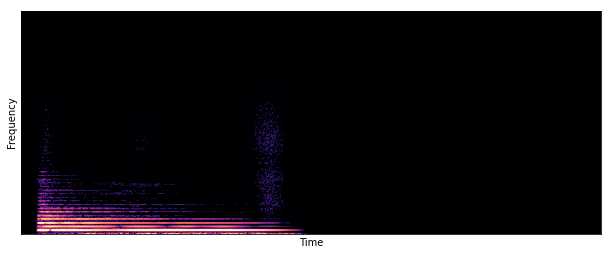

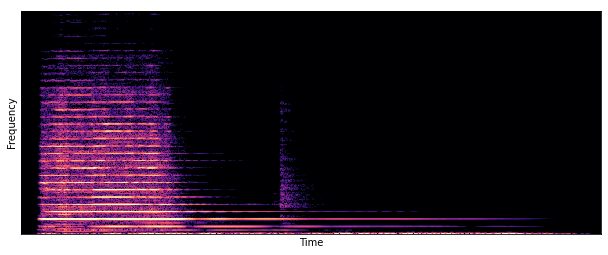

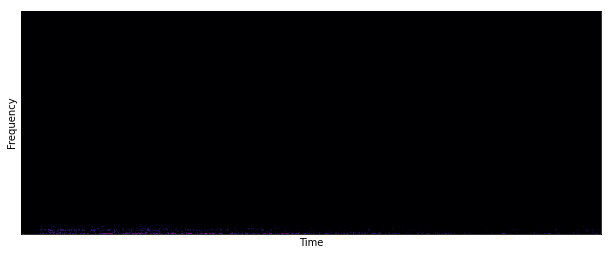

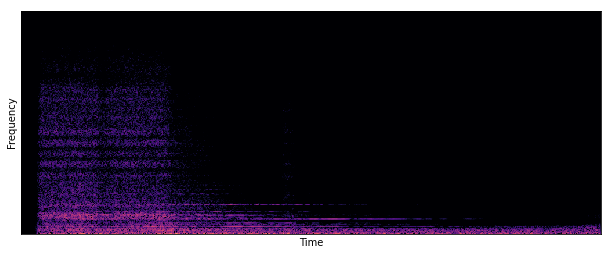

In [ ]:
from ddsp.colab.colab_utils import play, specplot, download
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

from scipy.io.wavfile import write as write_audio

data_provider_left = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_LEFT, sample_rate=sample_rate)
data_provider_right = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN_RIGHT, sample_rate=sample_rate)
dataset_left = data_provider_left.get_batch(batch_size=1, shuffle=False)
dataset_right = data_provider_right.get_batch(batch_size=1, shuffle=False)

try:
  batch_left = next(iter(dataset_left))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')
  
try:
  batch_right = next(iter(dataset_right))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin configs.
if DRIVE_DIR:
  gin_file_left = os.path.join(SAVE_DIR_LEFT, 'operative_config-0.gin')
  gin_file_right = os.path.join(SAVE_DIR_RIGHT, 'operative_config-0.gin')
else:
  gin_file_left = os.path.join(MODEL_DIR_LEFT, 'operative_config-0.gin')
  gin_file_right = os.path.join(MODEL_DIR_RIGHT, 'operative_config-0.gin')

gin.parse_config_file(gin_file_left)
gin.parse_config_file(gin_file_right)

# Load models
model_left = ddsp.training.models.Autoencoder()
model_right = ddsp.training.models.Autoencoder()

if DRIVE_DIR:
  model_left.restore(SAVE_DIR_LEFT)
  model_right.restore(SAVE_DIR_RIGHT)
else:
  model_left.restore(MODEL_DIR_LEFT)
  model_right.restore(MODEL_DIR_RIGHT)

# Resynthesize audio.
audio_left = batch_left['audio']
audio_right = batch_right['audio']

outputs_left = model_left(batch_left, training=False)
audio_gen_left = model_left.get_audio_from_outputs(outputs_left)
outputs_right = model_right(batch_right, training=False)
audio_gen_right = model_right.get_audio_from_outputs(outputs_right)

# Merge to stereo.
audio_left_stereo = np.expand_dims(np.squeeze(audio_left.numpy()), axis=1)
audio_right_stereo = np.expand_dims(np.squeeze(audio_right.numpy()), axis=1)
audio_stereo = np.concatenate((audio_left_stereo, audio_right_stereo), axis=1)

audio_gen_left_stereo = np.expand_dims(np.squeeze(audio_gen_left.numpy()), axis=1)
audio_gen_right_stereo = np.expand_dims(np.squeeze(audio_gen_right.numpy()), axis=1)
audio_gen_stereo = np.concatenate((audio_gen_left_stereo, audio_gen_right_stereo), axis=1)

# Play.
print('Original Audio')
play(audio_stereo, sample_rate=sample_rate)

print('Resynthesis')
play(audio_gen_stereo, sample_rate=sample_rate)

# Plot.
print('Spectrograms: Top two are Original Audio L/R, bottom two are Resynthesis L/R')
specplot(audio_left)
specplot(audio_right)
specplot(audio_gen_left)
specplot(audio_gen_right)

WRITE_PATH = OUTPUT_DIR + "/resynthesis.wav"

write_audio("resynthesis.wav", sample_rate, audio_gen_stereo)
write_audio(WRITE_PATH, sample_rate, audio_gen_stereo)

!ffmpeg-normalize resynthesis.wav -o resynthesis.wav -t -15 -ar 48000 -f

colab_utils.download("resynthesis.wav")

## Timbre Transfer

### Install & Import

Install ddsp, define some helper functions, and download the model. This transfers a lot of data and should take a minute or two.

In [9]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = 48000
n_fft = 2048

print('Done!')

Done!


### Primer Audio File

In [23]:
#@markdown * Audio should be monophonic (single instrument / voice).
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 
#@markdown * Choose an audio file on Drive or upload an audio file.
#@markdown * If you are using Drive, place the audio file in the "primers" folder inside the DRIVE_DIR folder. Enter the file name below.

from google.colab import files
from ddsp.colab.colab_utils import play

import re

PRIMER_FILE =  "bass1_Transmission_038M01.wav" #@param {type:"string"}

DRIVE_OR_UPLOAD = "Drive"  #@param ["Drive", "Upload (.wav)"]

# Check for .wav extension.
match = re.search(r'.wav', PRIMER_FILE)
if match:
  print ('')
else:
  PRIMER_FILE = PRIMER_FILE + ".wav"

if DRIVE_OR_UPLOAD == "Drive":
  PRIMER_PATH = PRIMERS_DIR + "/" + PRIMER_FILE
  # Convert to 48kHz.
  audio, unused_sample_rate = librosa.load(PRIMER_PATH, sr=48000, mono=False)
  if (audio.ndim == 2):
    audio = np.swapaxes(audio, 0, 1)
else:
  # Load audio sample here (.wav file)
  # Just use the first file.
  audio_files = files.upload()
  fnames = list(audio_files.keys())
  audios = []
  for fname in fnames:
    audio, unused_sample_rate = librosa.load(fname, sr=48000, mono=False)
  if (audio.ndim == 2):
    audio = np.swapaxes(audio, 0, 1)
    audios.append(audio)
  audio = audios[0]

# Mono to stereo.
if (audio.ndim == 1):
  print('Converting mono to stereo.')
  audio = np.stack((audio, audio), axis=-1)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
audio_left = np.squeeze(audio[:, 0]).astype(np.float32)
audio_right = np.squeeze(audio[:, 1]).astype(np.float32)
audio_left = audio_left[np.newaxis, :]
audio_right = audio_right[np.newaxis, :]

start_time = time.time()
audio_features_left = ddsp.training.metrics.compute_audio_features(audio_left, n_fft=n_fft, sample_rate=sample_rate)
audio_features_right = ddsp.training.metrics.compute_audio_features(audio_right, n_fft=n_fft, sample_rate=sample_rate)

audio_features_left['loudness_db'] = audio_features_left['loudness_db'].astype(np.float32)
audio_features_right['loudness_db'] = audio_features_right['loudness_db'].astype(np.float32)
audio_features_mod_left = None
audio_features_mod_right = None
print('Audio features took %.1f seconds' % (time.time() - start_time))

play(audio, sample_rate=sample_rate)

TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=6, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 16))
ax[0].plot(audio_features_left['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db L')

ax[1].plot(audio_features_right['loudness_db'][:TRIM])
ax[1].set_ylabel('loudness_db R')

ax[2].plot(librosa.hz_to_midi(audio_features_left['f0_hz'][:TRIM]))
ax[2].set_ylabel('f0 [midi] L')

ax[3].plot(librosa.hz_to_midi(audio_features_right['f0_hz'][:TRIM]))
ax[3].set_ylabel('f0 [midi] R')

ax[4].plot(audio_features_left['f0_confidence'][:TRIM])
ax[4].set_ylabel('f0 confidence L')
_ = ax[4].set_xlabel('Time step [frame] L')

ax[5].plot(audio_features_right['f0_confidence'][:TRIM])
ax[5].set_ylabel('f0 confidence R')
_ = ax[5].set_xlabel('Time step [frame] R')

FileNotFoundError: ignored

## Load the Model

In [11]:
def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 

if DRIVE_DIR:
  model_dir_left = find_model_dir(SAVE_DIR_LEFT)
  model_dir_right = find_model_dir(SAVE_DIR_RIGHT)
else:
  model_dir_left = find_model_dir(MODEL_DIR_LEFT)
  model_dir_right = find_model_dir(MODEL_DIR_RIGHT)

gin_file_left = os.path.join(model_dir_left, 'operative_config-0.gin')
gin_file_right = os.path.join(model_dir_right, 'operative_config-0.gin')

# Load the dataset statistics.
DATASET_STATS_LEFT = None
DATASET_STATS_RIGHT = None
dataset_stats_file_left = os.path.join(model_dir_left, 'dataset_statistics_left.pkl')
dataset_stats_file_right = os.path.join(model_dir_right, 'dataset_statistics_right.pkl')

print(f'Loading dataset statistics from {dataset_stats_file_left}')
try:
  if tf.io.gfile.exists(dataset_stats_file_left):
    with tf.io.gfile.GFile(dataset_stats_file_left, 'rb') as f:
      DATASET_STATS_LEFT = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))

print(f'Loading dataset statistics from {dataset_stats_file_right}')
try:
  if tf.io.gfile.exists(dataset_stats_file_right):
    with tf.io.gfile.GFile(dataset_stats_file_right, 'rb') as f:
      DATASET_STATS_RIGHT = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))

# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file_left, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.

if DRIVE_DIR:
  latest_checkpoint_fname_left = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR_LEFT))
  latest_checkpoint_fname_right = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR_RIGHT))
else:
  latest_checkpoint_fname_left = os.path.basename(tf.train.latest_checkpoint(MODEL_DIR_LEFT))
  latest_checkpoint_fname_right = os.path.basename(tf.train.latest_checkpoint(MODEL_DIR_RIGHT)) 

ckpt_left = os.path.join(model_dir_left, latest_checkpoint_fname_left)
ckpt_right = os.path.join(model_dir_right, latest_checkpoint_fname_right)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio_left.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Additive.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)

# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features_left[key] = audio_features_left[key][:time_steps]
  audio_features_right[key] = audio_features_right[key][:time_steps]
audio_features_left['audio'] = audio_features_left['audio'][:, :n_samples]
audio_features_right['audio'] = audio_features_right['audio'][:, :n_samples]

# Set up the model just to predict audio given new conditioning
model_left = ddsp.training.models.Autoencoder()
model_right = ddsp.training.models.Autoencoder()
model_left.restore(ckpt_left)
model_right.restore(ckpt_right)

# Build model by running a batch through it.
start_time = time.time()
unused_left = model_left(audio_features_left, training=False)
unused_right = model_right(audio_features_right, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /content/drive/My Drive/DDSP48--OTO-Chorus/ddsp-solo-instrument-left/dataset_statistics_left.pkl
Loading dataset statistics from /content/drive/My Drive/DDSP48--OTO-Chorus/ddsp-solo-instrument-right/dataset_statistics_right.pkl
Restoring model took 72.7 seconds


Autotuning... 
Inferred key: C  
Tuning offset: 33 cents
Autotuning... 
Inferred key: C  
Tuning offset: 29 cents


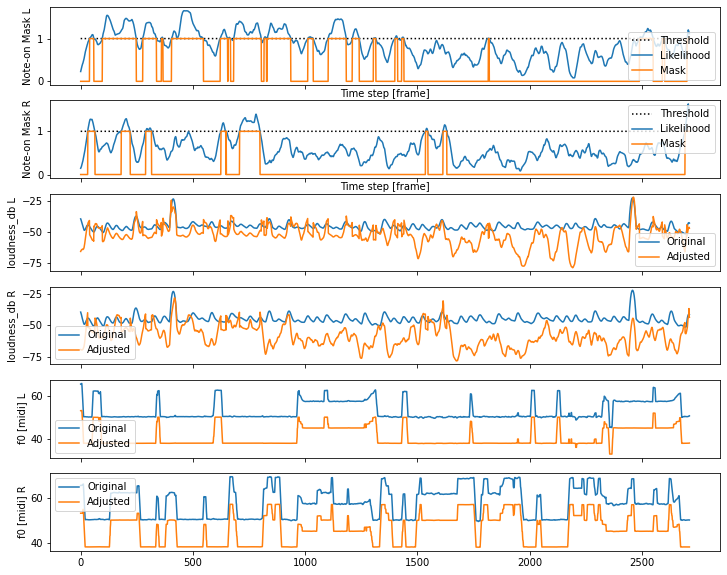

In [21]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 41 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0.8 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  -2 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjsut the overall loudness (dB)
loudness_shift = 5 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod_left = {k: v.copy() for k, v in audio_features_left.items()}
audio_features_mod_right = {k: v.copy() for k, v in audio_features_right.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on_left = None
mask_on_right = None


if ADJUST and DATASET_STATS_LEFT and DATASET_STATS_RIGHT is not None:
  # Detect sections that are "on".
  mask_on_left, note_on_value_left = detect_notes(audio_features_left['loudness_db'],
                                        audio_features_left['f0_confidence'],
                                        threshold)
  
  mask_on_right, note_on_value_right = detect_notes(audio_features_right['loudness_db'],
                                        audio_features_right['f0_confidence'],
                                        threshold)

  if np.any(mask_on_left) or np.any(mask_on_right):
    # Shift the pitch register.
    target_mean_pitch_left = DATASET_STATS_LEFT['mean_pitch']
    target_mean_pitch_right = DATASET_STATS_RIGHT['mean_pitch']
    pitch_left = ddsp.core.hz_to_midi(audio_features_left['f0_hz'])
    pitch_right = ddsp.core.hz_to_midi(audio_features_right['f0_hz'])
    mean_pitch_left = np.mean(pitch_left[mask_on_left])
    mean_pitch_right = np.mean(pitch_right[mask_on_right])
    p_diff_left = target_mean_pitch_left - mean_pitch_left
    p_diff_right = target_mean_pitch_right - mean_pitch_right
    p_diff_octave_left = p_diff_left / 12.0
    p_diff_octave_right = p_diff_right / 12.0
    round_fn_left = np.floor if p_diff_octave_left > 1.5 else np.ceil
    round_fn_right = np.floor if p_diff_octave_right > 1.5 else np.ceil
    p_diff_octave_left = round_fn_left(p_diff_octave_left)
    p_diff_octave_right = round_fn_right(p_diff_octave_right)
    audio_features_mod_left = shift_f0(audio_features_mod_left, p_diff_octave_left)
    audio_features_mod_right = shift_f0(audio_features_mod_right, p_diff_octave_right)

    # Quantile shift the note_on parts.
    _, loudness_norm_left = colab_utils.fit_quantile_transform(
        audio_features_left['loudness_db'],
        mask_on_left,
        inv_quantile=DATASET_STATS_LEFT['quantile_transform'])
    
    _, loudness_norm_right = colab_utils.fit_quantile_transform(
        audio_features_right['loudness_db'],
        mask_on_right,
        inv_quantile=DATASET_STATS_RIGHT['quantile_transform'])

    # Turn down the note_off parts.
    mask_off_left = np.logical_not(mask_on_left)
    mask_off_right = np.logical_not(mask_on_right)
    loudness_norm_left[mask_off_left] -=  quiet * (1.0 - note_on_value_left[mask_off_left][:, np.newaxis])
    loudness_norm_right[mask_off_right] -=  quiet * (1.0 - note_on_value_right[mask_off_right][:, np.newaxis])
    loudness_norm_left = np.reshape(loudness_norm_left, audio_features_left['loudness_db'].shape)
    loudness_norm_right = np.reshape(loudness_norm_right, audio_features_right['loudness_db'].shape)
    
    audio_features_mod_left['loudness_db'] = loudness_norm_left
    audio_features_mod_right['loudness_db'] = loudness_norm_right 

    # Auto-tune.
    if autotune:
      f0_midi_left = np.array(ddsp.core.hz_to_midi(audio_features_mod_left['f0_hz']))
      f0_midi_right = np.array(ddsp.core.hz_to_midi(audio_features_mod_right['f0_hz']))
      tuning_factor_left = get_tuning_factor(f0_midi_left, audio_features_mod_left['f0_confidence'], mask_on_left)
      tuning_factor_right = get_tuning_factor(f0_midi_right, audio_features_mod_right['f0_confidence'], mask_on_right)
      f0_midi_at_left = auto_tune(f0_midi_left, tuning_factor_left, mask_on_left, amount=autotune)
      f0_midi_at_right = auto_tune(f0_midi_right, tuning_factor_right, mask_on_right, amount=autotune)
      audio_features_mod_left['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at_left)
      audio_features_mod_right['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at_right)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod_left = shift_ld(audio_features_mod_left, loudness_shift)
audio_features_mod_right = shift_ld(audio_features_mod_right, loudness_shift)
audio_features_mod_left = shift_f0(audio_features_mod_left, pitch_shift)
audio_features_mod_right = shift_f0(audio_features_mod_right, pitch_shift)

# Plot Features.
has_mask_left = int(mask_on_left is not None)
has_mask_right = int(mask_on_right is not None)
n_plots = 4 + has_mask_left + has_mask_right
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 10))

if has_mask_left:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on_left[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value_left[:TRIM])
  ax.plot(mask_on_left[:TRIM])
  ax.set_ylabel('Note-on Mask L')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

if has_mask_right:
  ax = axes[0 + has_mask_left]
  ax.plot(np.ones_like(mask_on_right[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value_right[:TRIM])
  ax.plot(mask_on_right[:TRIM])
  ax.set_ylabel('Note-on Mask R')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask_left + has_mask_right]
ax.plot(audio_features_left['loudness_db'][:TRIM])
ax.plot(audio_features_mod_left['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db L')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask_left + has_mask_right]
ax.plot(audio_features_right['loudness_db'][:TRIM])
ax.plot(audio_features_mod_right['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db R')
ax.legend(['Original','Adjusted'])

ax = axes[2 + has_mask_left + has_mask_right]
ax.plot(librosa.hz_to_midi(audio_features_left['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod_left['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi] L')
_ = ax.legend(['Original','Adjusted'])

ax = axes[3 + has_mask_left + has_mask_right]
ax.plot(librosa.hz_to_midi(audio_features_right['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod_right['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi] R')
_ = ax.legend(['Original','Adjusted'])

In [22]:
from scipy.io.wavfile import write as write_audio

#@title #Resynthesize Audio

af_left = audio_features_left if audio_features_mod_left is None else audio_features_mod_left
af_right = audio_features_right if audio_features_mod_right is None else audio_features_mod_right

# Run a batch of predictions.
start_time = time.time()
outputs_left = model_left(af_left, training=False)
audio_gen_left = model_left.get_audio_from_outputs(outputs_left)
outputs_right = model_right(af_right, training=False)
audio_gen_right = model_right.get_audio_from_outputs(outputs_right)

print('Prediction took %.1f seconds' % (time.time() - start_time))

# Merge to stereo.
audio_gen_left = np.expand_dims(np.squeeze(audio_gen_left.numpy()), axis=1)
audio_gen_right = np.expand_dims(np.squeeze(audio_gen_right.numpy()), axis=1)
audio_gen_stereo = np.concatenate((audio_gen_left, audio_gen_right), axis=1)

# Play
print('Resynthesis with primer')
play(audio_gen_stereo, sample_rate=sample_rate)

WRITE_PATH = OUTPUT_DIR + "/resynthesis_primer.wav"

write_audio("resynthesis_primer.wav", sample_rate, audio_gen_stereo)
write_audio(WRITE_PATH, sample_rate, audio_gen_stereo)

!ffmpeg-normalize resynthesis_primer.wav -o resynthesis_primer.wav -t -15 -ar 48000 -f

colab_utils.download("resynthesis_primer.wav")

Prediction took 4.5 seconds
Resynthesis with primer


/bin/bash: ffmpeg-normalize: command not found


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>